In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Load raw data
df = pd.read_csv("../data/social_media_vs_productivity.csv")

# Target
target = "actual_productivity_score"

# Drop rows with missing target (cannot train without y)
df = df[df[target].notna()].copy()

# Feature groups
num_cols = [
    'age','daily_social_media_time','number_of_notifications','work_hours_per_day',
    'perceived_productivity_score','actual_productivity_score','stress_level','sleep_hours',
    'screen_time_before_sleep','breaks_during_work','coffee_consumption_per_day',
    'days_feeling_burnout_per_month','weekly_offline_hours','job_satisfaction_score'
]
cat_cols = ['gender','job_type','social_platform_preference','uses_focus_apps','has_digital_wellbeing_enabled']

# X / y
X = df[num_cols + cat_cols].copy()
y = df[target].copy()

# Train/test split (hold-out test set)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

# Preprocessing in a ColumnTransformer (no leakage)
numeric_pipeline = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(drop="first", sparse_output=False, handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipeline, [c for c in num_cols if c != target]),  # exclude target from scaling
        ("cat", categorical_pipeline, cat_cols)
    ],
    remainder='drop'
)

# Define models wrapped in Pipelines
models = {
    "LinearRegression": Pipeline([
        ("prep", preprocess),
        ("model", LinearRegression())
    ]),
    "RidgeCV": Pipeline([
        ("prep", preprocess),
        ("model", RidgeCV(alphas=np.logspace(-3, 3, 13)))
    ]),
    "LassoCV": Pipeline([
        ("prep", preprocess),
        ("model", LassoCV(alphas=np.logspace(-3, 1, 9), max_iter=5000, random_state=42))
    ]),
    "DecisionTree": Pipeline([
        ("prep", preprocess),
        ("model", DecisionTreeRegressor(random_state=42))
    ]),
    "RandomForest": Pipeline([
        ("prep", preprocess),
        ("model", RandomForestRegressor(
            n_estimators=300, max_depth=20, min_samples_split=5,
            min_samples_leaf=2, max_features="sqrt", bootstrap=False, random_state=42
        ))
    ]),
    "GradientBoosting": Pipeline([
        ("prep", preprocess),
        ("model", GradientBoostingRegressor(random_state=42))
    ])
}

# Fit, predict, evaluate on the held-out test set
rows = []
for name, pipe in models.items():
    pipe.fit(X_train, y_train)
    pred = pipe.predict(X_test)
    r2  = r2_score(y_test, pred)
    mae = mean_absolute_error(y_test, pred)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    rows.append({"Model": name, "R2": r2, "MAE": mae, "RMSE": rmse})

results = pd.DataFrame(rows).sort_values("RMSE").reset_index(drop=True)
results


,Model,R2,MAE,RMSE
0,GradientBoosting,0.924841,0.400376,0.520348
1,RandomForest,0.917211,0.417657,0.546122
2,LassoCV,0.905853,0.428230,0.582381
3,LinearRegression,0.905758,0.428421,0.582674
4,RidgeCV,0.905755,0.428460,0.582684
5,DecisionTree,0.845052,0.571291,0.747132


In [3]:
from sklearn.model_selection import KFold, cross_val_score

cv = KFold(n_splits=5, shuffle=True, random_state=42)

rows = []
for name, pipe in models.items():
    r2_scores = cross_val_score(pipe, X, y, scoring="r2", cv=cv, n_jobs=-1)
    mae_scores = cross_val_score(pipe, X, y, scoring="neg_mean_absolute_error", cv=cv, n_jobs=-1)
    rmse_scores = cross_val_score(pipe, X, y, scoring="neg_root_mean_squared_error", cv=cv, n_jobs=-1)

    rows.append({
        "Model": name,
        "R2 (mean)":  r2_scores.mean(),
        "R2 (std)":   r2_scores.std(),
        "MAE (mean)": -mae_scores.mean(),
        "MAE (std)":  mae_scores.std(),
        "RMSE (mean)": -rmse_scores.mean(),
        "RMSE (std)":  rmse_scores.std(),
    })

cv_df = pd.DataFrame(rows).sort_values("RMSE (mean)").reset_index(drop=True)
cv_df


,Model,R2 (mean),R2 (std),MAE (mean),MAE (std),RMSE (mean),RMSE (std)
0,GradientBoosting,0.926198,0.002500,0.393239,0.005836,0.511448,0.007103
1,RandomForest,0.919279,0.002197,0.410538,0.004545,0.534929,0.006643
2,LassoCV,0.907439,0.002197,0.422197,0.004073,0.572829,0.005986
3,RidgeCV,0.907387,0.002204,0.422448,0.004031,0.572992,0.006045
4,LinearRegression,0.907386,0.002205,0.422422,0.004031,0.572993,0.006044
5,DecisionTree,0.848968,0.003067,0.563305,0.004074,0.731753,0.007971


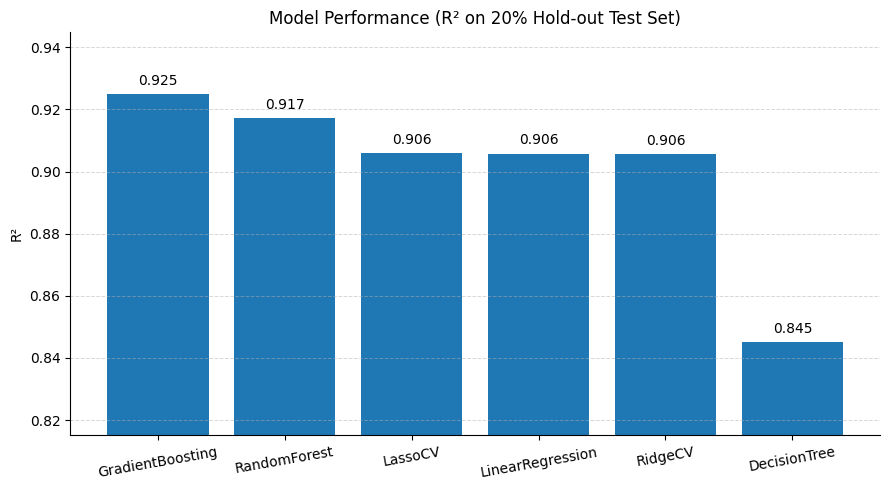

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt

os.makedirs("../reports/figures", exist_ok=True)

plot_df = results.sort_values("R2", ascending=False).reset_index(drop=True)

plt.figure(figsize=(9,5))
bars = plt.bar(plot_df["Model"], plot_df["R2"])

# light horizontal grid for readability
plt.grid(axis="y", linestyle="--", linewidth=0.7, alpha=0.5)

# set a tight y-range around your scores
ymin = max(0.0, plot_df["R2"].min() - 0.03)
ymax = min(1.0, plot_df["R2"].max() + 0.02)
plt.ylim(ymin, ymax)

# value labels on bars
for b, v in zip(bars, plot_df["R2"]):
    plt.text(b.get_x() + b.get_width()/2, v + 0.002, f"{v:.3f}",
             ha="center", va="bottom", fontsize=10)

# subtle cleanup
for spine in ["top", "right"]:
    plt.gca().spines[spine].set_visible(False)

plt.title("Model Performance (R² on 20% Hold-out Test Set)")
plt.ylabel("R²")
plt.xlabel("")
plt.xticks(rotation=10)
plt.tight_layout()
plt.savefig("../reports/figures/model_comparison.png", dpi=300)
plt.show()


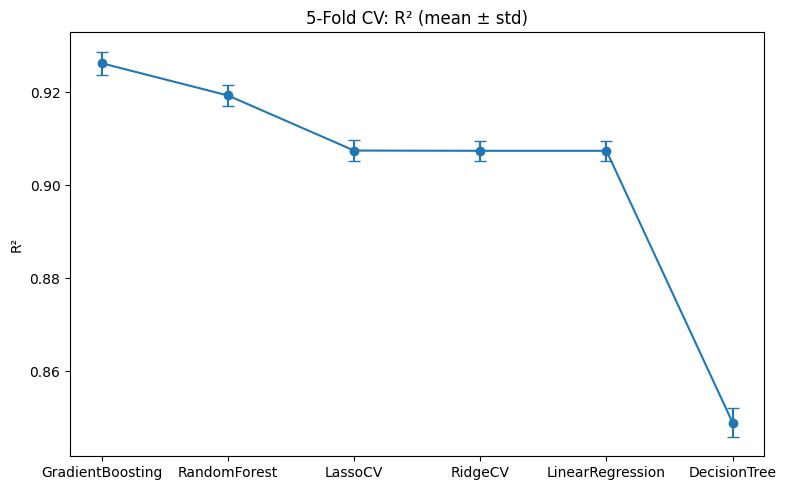

In [21]:
cv_plot = cv_df.sort_values("R2 (mean)", ascending=False).reset_index(drop=True)

plt.figure(figsize=(8,5))
plt.errorbar(
    x=cv_plot["Model"], y=cv_plot["R2 (mean)"],
    yerr=cv_plot["R2 (std)"], fmt="o-", capsize=4
)
plt.title("5-Fold CV: R² (mean ± std)")
plt.ylabel("R²")
plt.xlabel("")
plt.tight_layout()
plt.savefig("../reports/figures/model_cv_r2.png", dpi=300)
plt.show()


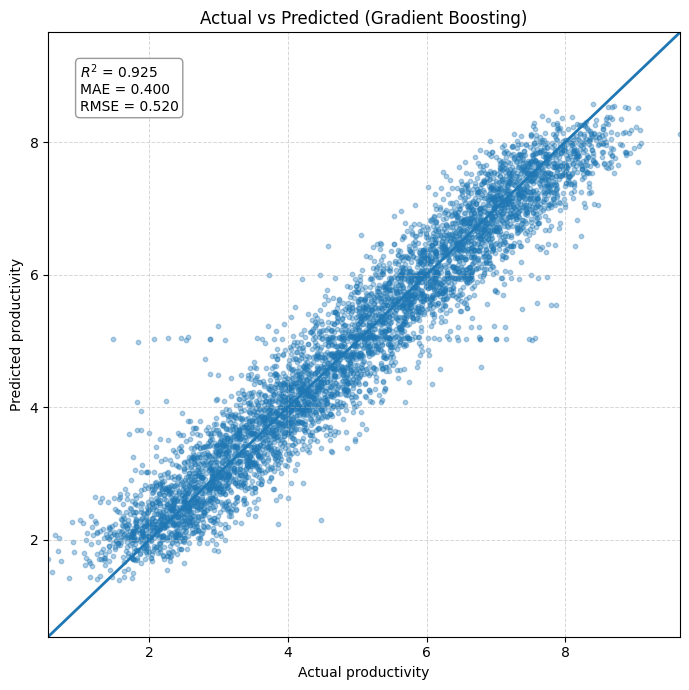

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Fit & predict (if not already)
best_pipe = models["GradientBoosting"]
best_pipe.fit(X_train, y_train)
y_pred = best_pipe.predict(X_test)

# Metrics for a small annotation box
r2  = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

plt.figure(figsize=(7,7))
plt.scatter(y_test, y_pred, s=10, alpha=0.35)  # smaller points + transparency

# 45° reference line
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, linewidth=2)               # bold diagonal
plt.xlim(lims); plt.ylim(lims)

plt.title("Actual vs Predicted (Gradient Boosting)")
plt.xlabel("Actual productivity")
plt.ylabel("Predicted productivity")
plt.grid(linestyle="--", linewidth=0.7, alpha=0.5)

# neat metrics box
txt = f"$R^2$ = {r2:.3f}\nMAE = {mae:.3f}\nRMSE = {rmse:.3f}"
plt.gca().text(0.05, 0.95, txt, transform=plt.gca().transAxes,
               va="top", ha="left", bbox=dict(boxstyle="round", fc="white", ec="0.6"))

plt.tight_layout()
plt.savefig("../reports/figures/actual_vs_pred.png", dpi=300)
plt.show()


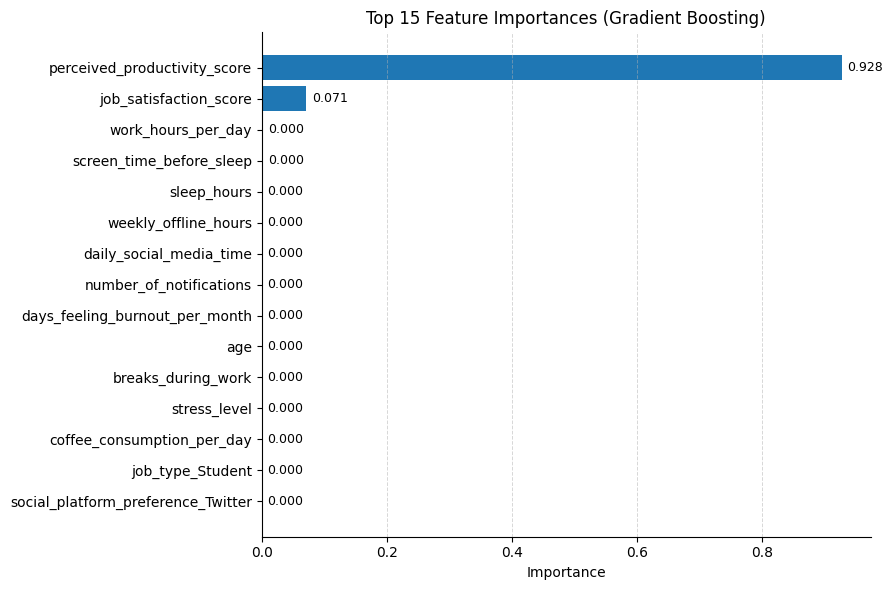

In [8]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Build readable feature names from the ColumnTransformer
preproc = best_pipe.named_steps["prep"]
num_features = [c for c in num_cols if c != target]
cat_ohe = preproc.named_transformers_["cat"].named_steps["onehot"]
cat_features = list(cat_ohe.get_feature_names_out(cat_cols))
all_features = num_features + cat_features

importances = best_pipe.named_steps["model"].feature_importances_
feat_imp = pd.Series(importances, index=all_features).sort_values(ascending=False)

topk = 15
plot_series = feat_imp.head(topk).iloc[::-1]  # reverse for top at the top

plt.figure(figsize=(9,6))
bars = plt.barh(plot_series.index, plot_series.values)

# light grid
plt.grid(axis="x", linestyle="--", linewidth=0.7, alpha=0.5)

# value labels at the end of the bars
for y, v in enumerate(plot_series.values):
    plt.text(v + plot_series.values.max()*0.01, y, f"{v:.3f}", va="center", fontsize=9)

# remove spines for a clean look
for spine in ["top", "right"]:
    plt.gca().spines[spine].set_visible(False)

plt.title(f"Top {topk} Feature Importances (Gradient Boosting)")
plt.xlabel("Importance")
plt.ylabel("")
plt.tight_layout()
os.makedirs("../reports/figures", exist_ok=True)
plt.savefig("../reports/figures/feature_importance.png", dpi=300)
plt.show()
